엑셀 파일 업로드(.xlsx/.xls)


Saving 202501_04_clean.xlsx to 202501_04_clean (1).xlsx
선택된 시트: Sheet1

[DEBUG] 유효 표본수 요약: {'Cr': 1092, 'Co': 1520, 'Ni': 1051, 'As': 1514, 'Cd': 1540, 'Sb': 918, 'Pb': 1277}


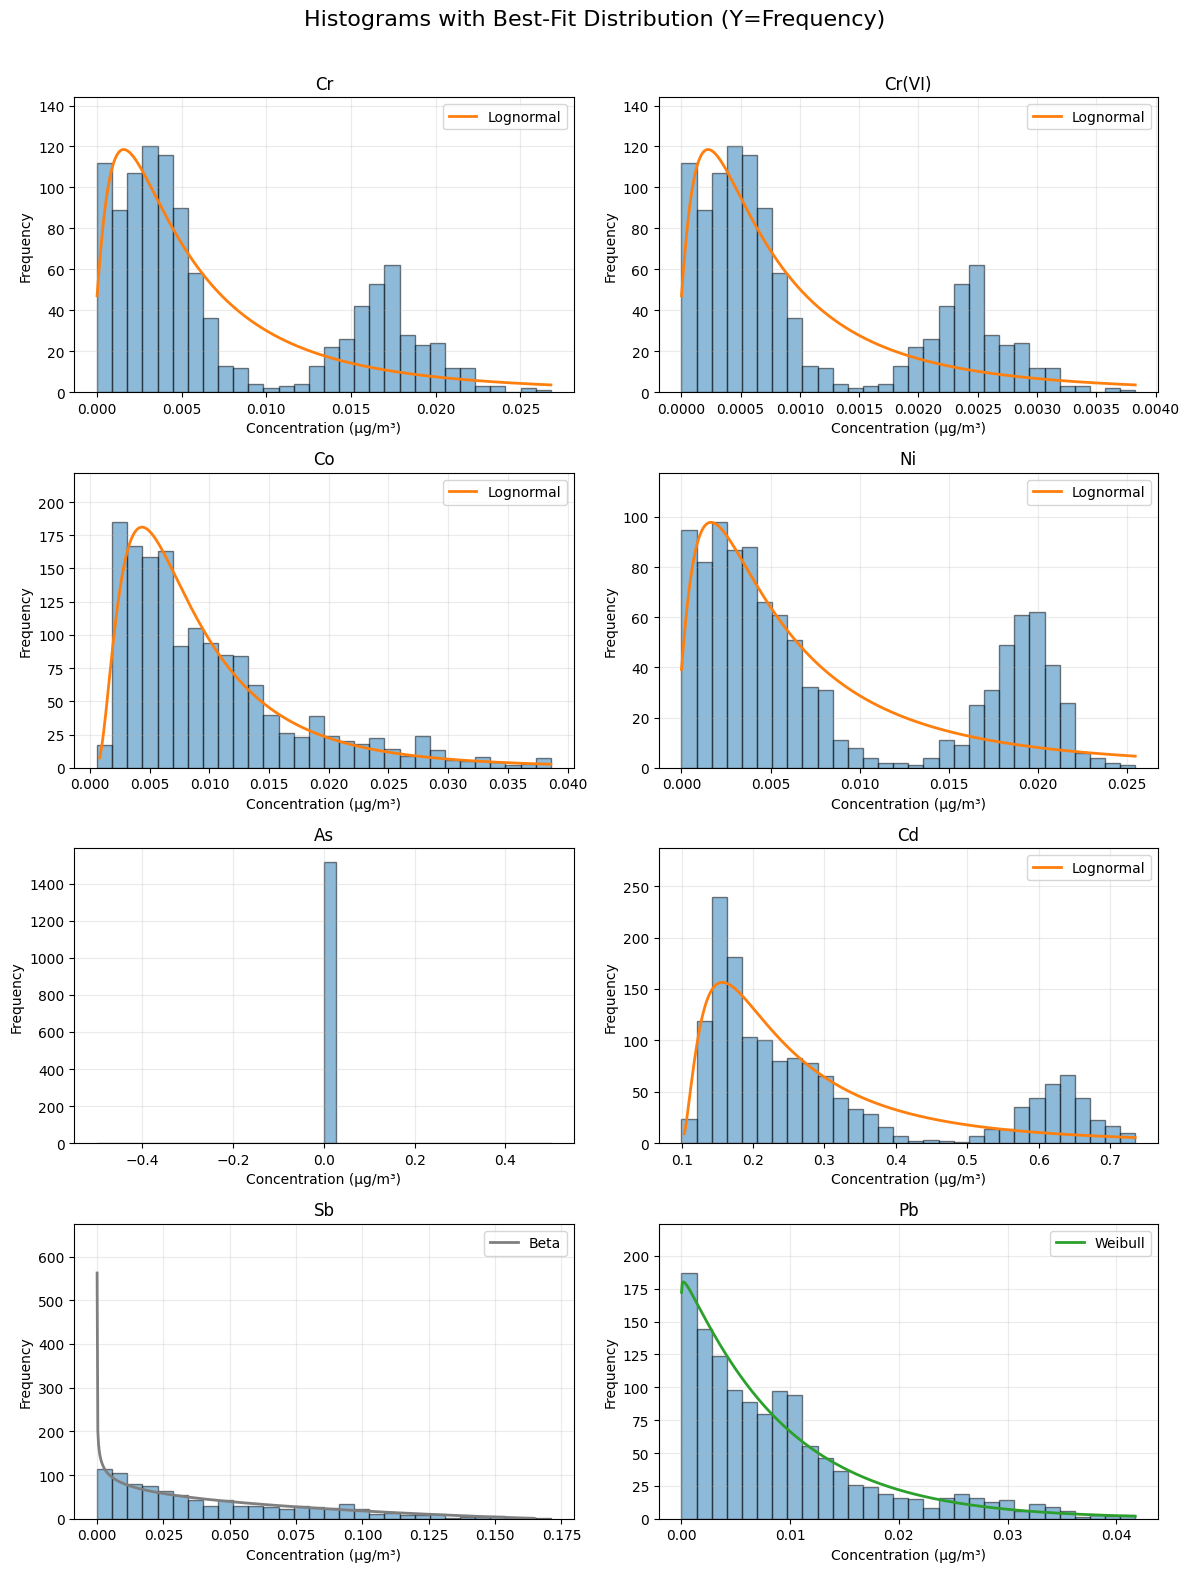

Saved: outputs/Tx_fit_result_Cd_included.xlsx

===== Monte Carlo 난수 샘플 (금속별 농도, µg/m³) =====
Cr: [0.0041  , 0.007682, 0.004707, 0.036724, 0.004053, 0.006756, 0.003946,
 0.001362, 0.001722, 0.017074]
Cr(VI): [1.330302e-03, 2.183491e-05, 1.776289e-05, 2.618716e-04, 1.639157e-04,
 5.101145e-04, 3.471117e-04, 9.441533e-04, 2.552338e-04, 7.120341e-04]
Co: [0.010262, 0.002956, 0.006873, 0.014141, 0.003934, 0.006445, 0.002031,
 0.003297, 0.021165, 0.002561]
Ni: [0.002764, 0.011547, 0.003393, 0.002239, 0.003945, 0.001228, 0.02965 ,
 0.009586, 0.001934, 0.002873]
As: [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
Cd: [0.248666, 0.359567, 0.974937, 0.256706, 0.196666, 0.194119, 0.197025,
 0.118019, 0.14896 , 0.140874]
Sb: [0.003861, 0.00282 , 0.057501, 0.001448, 0.00776 , 0.00645 , 0.008693,
 0.006916, 0.061939, 0.080835]
Pb: [0.010358, 0.021808, 0.008118, 0.011879, 0.005568, 0.025926, 0.017876,
 0.00357 , 0.00275 , 0.01615 ]

[C 검증] Cr
Raw(trimmed)       mean=7.543e-03, median=4.490e-03, p5=2.900e-04

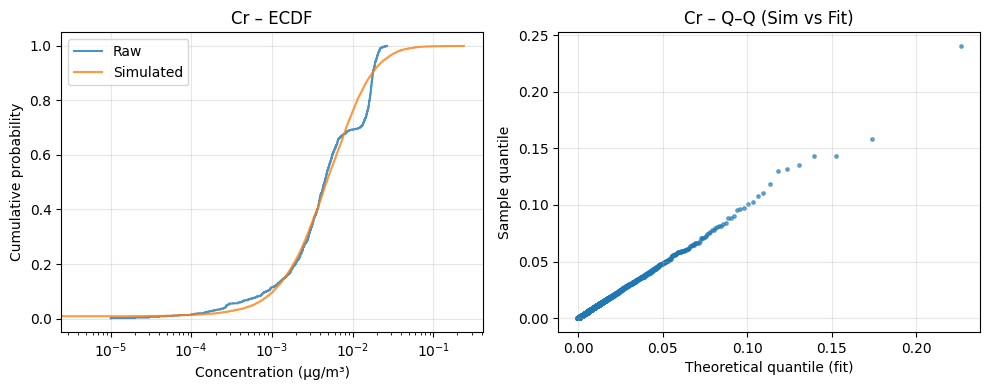


[C 검증] Cr(VI)
Raw(trimmed)       mean=1.078e-03, median=6.414e-04, p5=4.143e-05, p95=2.813e-03
Fitted(theory)     mean=1.142e-03, median=6.921e-04, p5=7.742e-05, p95=3.673e-03
Simulated(C_sims)  mean=1.130e-03, median=6.800e-04, p5=7.434e-05, p95=3.699e-03


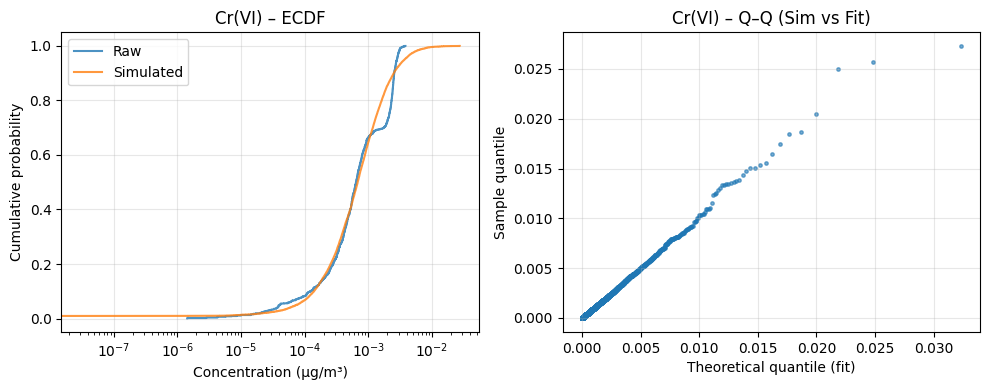


[C 검증] Co
Raw(trimmed)       mean=1.002e-02, median=7.825e-03, p5=2.360e-03, p95=2.639e-02
Fitted(theory)     mean=1.018e-02, median=7.641e-03, p5=2.322e-03, p95=2.634e-02
Simulated(C_sims)  mean=1.011e-02, median=7.581e-03, p5=2.304e-03, p95=2.599e-02


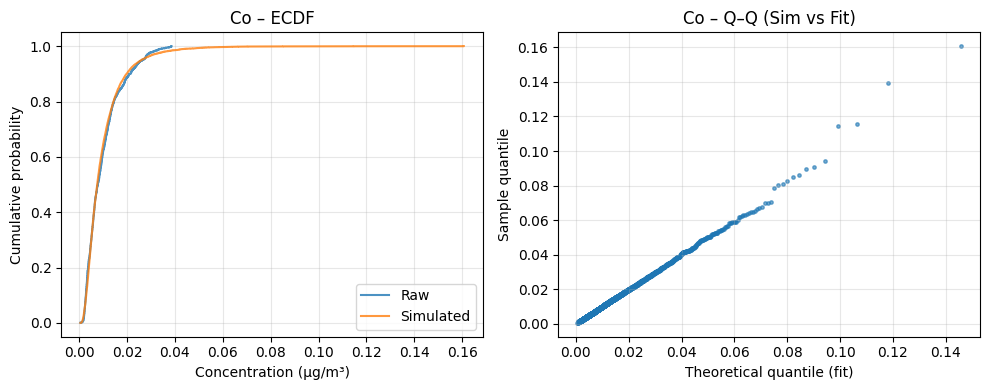


[C 검증] Ni
Raw(trimmed)       mean=8.549e-03, median=5.190e-03, p5=4.450e-04, p95=2.084e-02
Fitted(theory)     mean=9.263e-03, median=5.409e-03, p5=5.870e-04, p95=3.011e-02
Simulated(C_sims)  mean=9.154e-03, median=5.508e-03, p5=5.776e-04, p95=2.962e-02


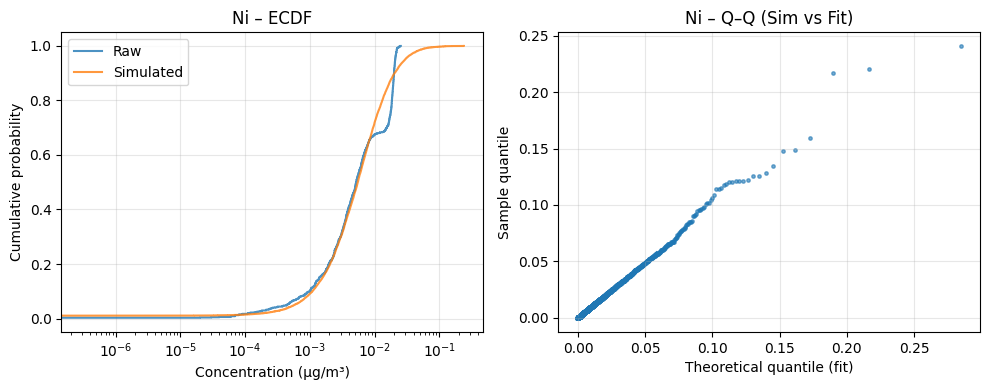


[C 검증] As
Raw(trimmed)       mean=0.000e+00, median=0.000e+00, p5=0.000e+00, p95=0.000e+00
Fitted(theory)   없음/피팅불가
Simulated(C_sims)  mean=0.000e+00, median=0.000e+00, p5=0.000e+00, p95=0.000e+00


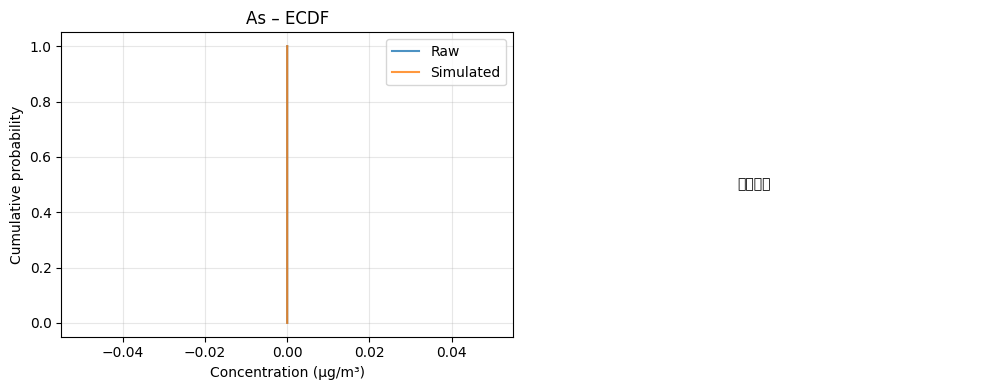


[C 검증] Cd
Raw(trimmed)       mean=3.022e-01, median=2.276e-01, p5=1.330e-01, p95=6.562e-01
Fitted(theory)     mean=3.069e-01, median=2.351e-01, p5=1.278e-01, p95=7.172e-01
Simulated(C_sims)  mean=3.089e-01, median=2.359e-01, p5=1.276e-01, p95=7.233e-01


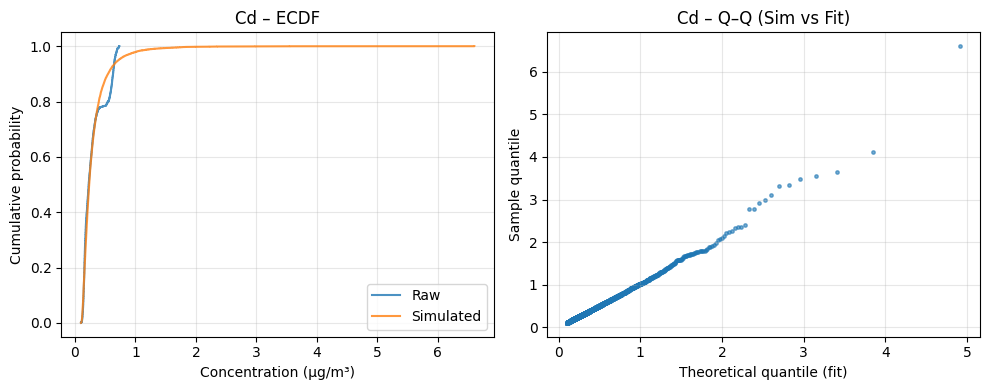


[C 검증] Sb
Raw(trimmed)       mean=4.279e-02, median=3.100e-02, p5=2.453e-03, p95=1.149e-01
Fitted(theory)     mean=4.450e-02, median=3.466e-02, p5=1.525e-03, p95=1.203e-01
Simulated(C_sims)  mean=4.492e-02, median=3.520e-02, p5=1.453e-03, p95=1.216e-01


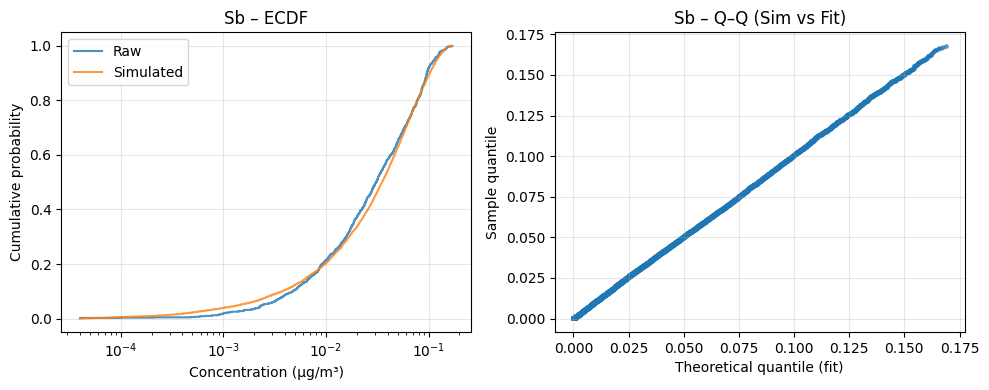


[C 검증] Pb
Raw(trimmed)       mean=9.127e-03, median=6.910e-03, p5=4.400e-04, p95=2.829e-02
Fitted(theory)     mean=9.123e-03, median=6.411e-03, p5=4.962e-04, p95=2.701e-02
Simulated(C_sims)  mean=9.321e-03, median=6.358e-03, p5=5.249e-04, p95=2.791e-02


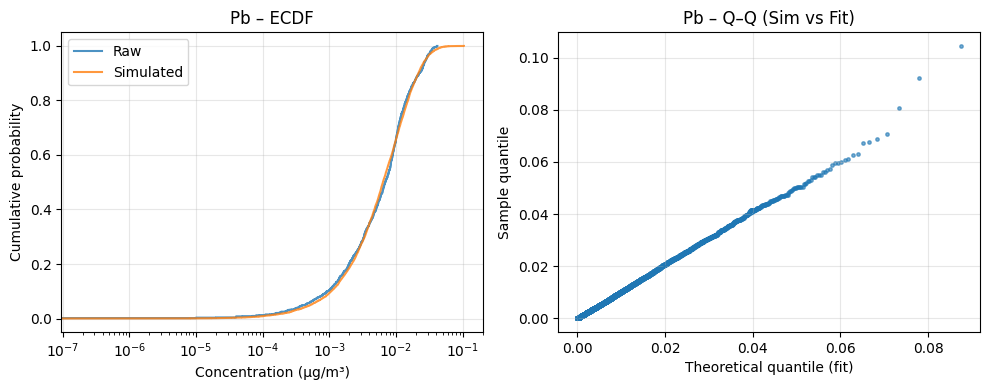


===== Time outdoors 난수 샘플 (min/day) =====
0-<1: [24., 24., 24., 24., 24., 24., 24., 24., 24., 24.]
1-<2: [84., 84., 84., 84., 84., 84., 84., 84., 84., 84.]
2-<3: [120., 120., 120., 120., 120., 120., 120., 120., 120., 120.]
3-<6: [108., 108., 108., 108., 108., 108., 108., 108., 108., 108.]
6-<11: [132., 132., 132., 132., 132., 132., 132., 132., 132., 132.]
11-<16: [102., 102., 102., 102., 102., 102., 102., 102., 102., 102.]
16-<18: [102., 102., 102., 102., 102., 102., 102., 102., 102., 102.]
18-<25: [ 43.167,  13.901,  43.685,  79.246,  38.294, 136.874,  34.633,  92.32 ,
 192.792,  24.571]
25-<35: [ 36.136,  71.012, 106.06 ,  12.302, 172.052,  97.098,  32.363,  17.024,
   8.799,  42.617]
35-<45: [ 30.891, 251.994,  13.913,  14.299,  10.22 , 106.497,  65.289, 159.326,
 939.882,   2.488]
45-<55: [  7.088,  15.608,  22.119,  27.278, 111.229, 442.222,  14.551,  13.12 ,
  24.235,  77.416]
55-<65: [ 30.565,  23.117,  26.645,  75.305,   8.201,  30.157, 366.525,  25.795,
 210.608,  49.732]
65-

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
# ============================================================
# 통합 파이프라인
# ============================================================

# ---------- Imports ----------
from google.colab import files
import os, re, json, math, warnings, glob
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kstest
from scipy.stats import (
    gumbel_r, gumbel_l, lognorm, weibull_min, logistic,
    norm, gamma, beta, triang, expon, pareto, uniform, chi2
)
from scipy.stats import t as student_t
from openpyxl import Workbook
from openpyxl.styles import Font, Alignment, PatternFill, Border, Side
from openpyxl.worksheet.table import Table, TableStyleInfo
warnings.filterwarnings("ignore")

# ---------- 사용자 설정 ----------
np.random.seed(20250912)
N_SIM       = 10_000
BOOTSTRAP_B = 200
CD_INCLUDE  = True
SAVE_DIR    = "outputs"

# ---------- 고정 상수 ----------
IUR = {"Cr(VI)":1.20e-02,"Co":9.00e-03,"Ni":2.40e-04,"As":4.30e-03,"Cd":1.80e-03,"Sb":2.29e-06,"Pb":1.20e-05}
ORDER = ['Cr','Cr(VI)','Co','Ni','As','Cd','Sb','Pb']

ENG_NAME = {
    '로그 정규':'Lognormal', '와이블':'Weibull', '감마':'Gamma', '지수':'Exponential',
    '최대 극값':'Gumbel Max', '최소 극값':'Gumbel Min', '정규':'Normal', '로지스틱':'Logistic',
    "스튜던트의 t":"Student's t", '베타':'Beta', 'BetaPERT':'BetaPERT',
    '삼각형':'Triangular', '균일':'Uniform', '파레토':'Pareto'}

# ===== [추가] 분포별 라인 색상 팔레트 =====
DIST_COLOR = {
    'Lognormal': 'tab:orange',
    'Weibull': 'tab:green',
    'Gamma': 'tab:purple',
    'Exponential': 'tab:red',
    'Gumbel Max': 'tab:olive',
    'Gumbel Min': 'tab:cyan',
    'Normal': 'tab:blue',
    'Logistic': 'tab:pink',
    "Student's t": 'tab:brown',
    'Beta': 'tab:gray',
    'BetaPERT': 'tab:purple',
    'Triangular': 'tab:teal',
    'Uniform': 'tab:cyan',
    'Pareto': 'tab:red',
}

# --- 패턴 ---
PAT = {
    "Cr(VI)": r"(?:\bCr\s*VI\b|\bCr[-\s]*VI\b|\bCr\s*6\+\b|Cr[-\s]*6\+|Hexa(?:valent)?\s*Chrom(?:ium)?|6가\s*크롬|육가\s*크롬|육가크롬)",
    "Cr"    : r"(?:\bCr\b(?!\s*(?:VI|6\+))|Chromium|크롬)",
    "Co"    : r"(?:\bCo\b|\bC\s*o\b|Cobalt|코발트)",
    "Ni"    : r"(?:\bNi\b|\bN\s*i\b|Nickel|니켈)",
    "As"    : r"(?:\bA\s*s\b|\bAs\b(?=[\s\(\[]|$)|Arsenic|비소)",
    "Cd"    : r"(?:\bCd\b|\bC\s*d\b|Cadmium|카드뮴)",
    "Sb"    : r"(?:\bS[bB]\b|\bS\s*B\b|Stibium|Antimon(?:y)?|안티몬)",
    "Pb"    : r"(?:\bPb\b|\bP\s*b\b|Lead|납)"
}

# Excel 스타일
HEADER_BLUE = '2F5597'; BEST_FILL='FFF2CC'; THIN_GRAY='999999'; TABLE_STYLE="TableStyleMedium9"

# 노출 파라미터
EF_days_per_year = 350; EF = EF_days_per_year/365.0
LT_years = 78.6
ACT_POINT = {"0-<1":24,"1-<2":84,"2-<3":120,"3-<6":108,"6-<11":132,"11-<16":102,"16-<18":102}
ACT_LN_P5_P95 = {"18-<25":(14.455,250.0),"25-<35":(6.516,220.0),"35-<45":(5.789,195.0),
                 "45-<55":(6.401,260.0),"55-<65":(8.083,350.0),"65-<78.6":(6.094,390.0)}
ED_years = {"0-<1":1,"1-<2":1,"2-<3":1,"3-<6":3,"6-<11":5,"11-<16":5,"16-<18":2,
            "18-<25":7,"25-<35":10,"35-<45":10,"45-<55":10,"55-<65":10,"65-<78.6":13.6}
AGE_ORDER=["0-<1","1-<2","2-<3","3-<6","6-<11","11-<16","16-<18","18-<25","25-<35","35-<45","45-<55","55-<65","65-<78.6"]
INFANT = ["0-<1","1-<2"]; CHILD=["2-<3","3-<6","6-<11","11-<16","16-<18"]; ADULT=["18-<25","25-<35","35-<45","45-<55","55-<65","65-<78.6"]

# RNG helpers
_master_rs = np.random.RandomState(20250912)
def child_rs(): return np.random.RandomState(_master_rs.randint(0, 2**31-1))
_mdl_rs = child_rs()  # ND/MDL 치환용 난수원

# ============================================================
# 유틸
# ============================================================
def freedman_diaconis_bins(x, min_bins=30, max_bins=70):
    x = np.asarray(x, float); x = x[np.isfinite(x)]
    n = x.size
    if n < 2: return max(2, min_bins)
    q75, q25 = np.percentile(x, [75, 25]); iqr = q75 - q25
    if iqr <= 0: return max(min_bins, min(max_bins, int(np.sqrt(n))))
    h = 2 * iqr * (n ** (-1/3))
    if h <= 0: return max(min_bins, min(max_bins, int(np.sqrt(n))))
    bins = int(np.ceil((x.max() - x.min()) / h))
    return max(2, max(min_bins, min(max_bins, bins)))

# --- ND/<MDL> 수치화 ---
MDL_POLICY = "uniform"  # "half" | "nan" | "uniform"
def coerce_numeric_with_mdl(s):
    s = pd.Series(s).astype(str).str.strip().str.replace(',', '', regex=False)

    # <a or ≤a → half*a / NaN / Uniform(0,a)
    m = s.str.match(r'^[<≤]\s*([0-9]*\.?[0-9]+)$')
    if m.any():
        vals = s[m].str.replace('≤','<',regex=False).str.replace('<','',regex=False).astype(float).values
        if MDL_POLICY == 'half':
            s.loc[m] = (vals/2.0)
        elif MDL_POLICY == 'nan':
            s.loc[m] = np.nan
        elif MDL_POLICY == 'uniform':
            # Uniform(0, a) 샘플
            u = _mdl_rs.uniform(0.0, 1.0, size=len(vals))
            s.loc[m] = vals * u
        else:
            s.loc[m] = (vals/2.0)

    # common tokens → NaN
    s = s.replace({'ND':np.nan,'N.D.':np.nan,'MDL':np.nan,'BDL':np.nan,'-':np.nan,'--':np.nan,'':np.nan}, regex=False)
    return pd.to_numeric(s, errors='coerce')

def hist_mode_estimate(x):
    x=np.asarray(x,float); x=x[np.isfinite(x)]
    if x.size<2: return float(np.nanmedian(x)) if x.size else np.nan
    iqr=np.subtract(*np.percentile(x,[75,25]))
    bins=max(10,int(np.sqrt(x.size))) if iqr<=0 else max(10,int(np.ceil((x.max()-x.min())/(2*iqr*x.size**(-1/3)))))
    cnt,edges=np.histogram(x,bins=bins); i=int(cnt.argmax())
    return float((edges[i]+edges[i+1])/2)

# ============================================================
# 1) 파일 업로드 & 시트 자동 선택
# ============================================================
print("엑셀 파일 업로드(.xlsx/.xls)")
up = files.upload()
INPUT = next((k for k in up if k.lower().endswith(('.xlsx','.xls'))), None)
if INPUT is None:
    cand = sorted(glob.glob("*.xlsx"))
    if not cand: raise FileNotFoundError("엑셀 파일을 찾지 못했습니다.")
    INPUT = cand[-1]

xls = pd.ExcelFile(INPUT)
sheet_scores=[]
for sh in xls.sheet_names:
    try:
        df_head = pd.read_excel(INPUT, sheet_name=sh, nrows=3)
    except Exception:
        df_head = pd.DataFrame()
    score=0
    for c in df_head.columns:
        s=str(c)
        score += sum(bool(re.search(p, s, flags=re.I)) for p in PAT.values())
    sheet_scores.append((sh,score))
sheet_scores.sort(key=lambda x:x[1], reverse=True)
SHEET = sheet_scores[0][0]
raw = pd.read_excel(INPUT, sheet_name=SHEET)
print(f"선택된 시트: {SHEET}")

# ============================================================
# 2) 단위 통일 & 열 자동 매칭 (+ Cr(VI) 파생)
# ============================================================
def find_col(df, regex):
    for c in df.columns:
        if re.search(regex, str(c), flags=re.I): return c
    return None

def to_ug(series, name):
    header = str(name)
    s = coerce_numeric_with_mdl(series).replace([np.inf, -np.inf], np.nan)
    has_ug = bool(re.search(r'(?i)[µμu]\s*g\s*/?\s*m\^?3', header))
    has_ng = bool(re.search(r'(?i)n\s*g\s*/?\s*m\^?3', header))
    if has_ug: return (s, 'as_is_ug')
    if has_ng: return (s/1000.0, 'converted_from_ng')
    return (s, 'as_is_ug')

series_map, log_rows = {}, []
for m in ORDER:
    if (m=='Cd') and (not CD_INCLUDE):
        log_rows.append((m, None, 'excluded_by_flag', 0, np.nan)); continue
    c = find_col(raw, PAT.get(m, r"^"))
    if c is None:
        log_rows.append((m, None, 'missing', 0, np.nan)); continue
    v, how = to_ug(raw[c], c); series_map[m]=v
    n_nonna = int(pd.to_numeric(v, errors='coerce').notna().sum())
    log_rows.append((m, c, how, n_nonna, float(np.nanmean(v))))
log = pd.DataFrame(log_rows, columns=['Metal','Matched_Column','Unit_Status','N_nonNa','Mean(ug/m3)'])

# 디버그 요약
print("\n[DEBUG] 유효 표본수 요약:", {m:int(pd.to_numeric(series_map[m],errors='coerce').notna().sum()) for m in series_map})

# Cr(VI) 파생 (없으면 Cr/7)
if ('Cr(VI)' not in series_map) and ('Cr' in series_map):
    series_map['Cr(VI)'] = series_map['Cr']/7.0
    log.loc[len(log)] = ['Cr(VI)','(derived from Cr/7)','derived',
                         int(pd.to_numeric(series_map['Cr(VI)'],errors='coerce').notna().sum()),
                         float(np.nanmean(series_map['Cr(VI)']))]

# ============================================================
# 3) 14개 분포 래퍼 + 적합도 함수
# ============================================================
class D:
    def __init__(self,name): self.name=name; self.p={}; self.np=None; self.valid=False
    def ok(self,p,np_): self.p=p; self.np=np_; self.valid=True; return self
    def cdf(self,z): raise NotImplementedError
    def ppf(self,q): raise NotImplementedError
    def rvs(self,n,rs=None): raise NotImplementedError

class LogNormal(D):
    def __init__(self): super().__init__('로그 정규')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<3: return self
        try: s,loc,sc=lognorm.fit(x)
        except: return self
        if s>0 and sc>0 and np.isfinite(loc): return self.ok({'s':s,'loc':loc,'scale':sc},3)
        return self
    def cdf(self,z): return lognorm.cdf(z, s=self.p['s'], loc=self.p['loc'], scale=self.p['scale'])
    def ppf(self,q): return lognorm.ppf(q, s=self.p['s'], loc=self.p['loc'], scale=self.p['scale'])
    def rvs(self,n,rs=None): return lognorm.rvs(self.p['s'], loc=self.p['loc'], scale=self.p['scale'], size=n, random_state=rs)

class Weibull(D):
    def __init__(self): super().__init__('와이블')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<3: return self
        try: c,loc,sc=weibull_min.fit(x)
        except: return self
        if c>0 and sc>0 and np.isfinite(loc): return self.ok({'c':c,'loc':loc,'scale':sc},3)
        return self
    def cdf(self,z): return weibull_min.cdf(z, c=self.p['c'], loc=self.p['loc'], scale=self.p['scale'])
    def ppf(self,q): return weibull_min.ppf(q, c=self.p['c'], loc=self.p['loc'], scale=self.p['scale'])
    def rvs(self,n,rs=None): return weibull_min.rvs(self.p['c'], loc=self.p['loc'], scale=self.p['scale'], size=n, random_state=rs)

class Gamma_(D):
    def __init__(self): super().__init__('감마')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<3: return self
        try: a,loc,sc=gamma.fit(x)
        except: return self
        if a>0 and sc>0 and np.isfinite(loc): return self.ok({'a':a,'loc':loc,'scale':sc},3)
        return self
    def cdf(self,z): return gamma.cdf(z, a=self.p['a'], loc=self.p['loc'], scale=self.p['scale'])
    def ppf(self,q): return gamma.ppf(q, a=self.p['a'], loc=self.p['loc'], scale=self.p['scale'])
    def rvs(self,n,rs=None): return gamma.rvs(self.p['a'], loc=self.p['loc'], scale=self.p['scale'], size=n, random_state=rs)

class LogisticD(D):
    def __init__(self): super().__init__('로지스틱')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<3: return self
        try: loc,sc=logistic.fit(x)
        except: return self
        if sc>0: return self.ok({'loc':loc,'scale':sc},2)
        return self
    def cdf(self,z): return logistic.cdf(z, **self.p)
    def ppf(self,q): return logistic.ppf(q, **self.p)
    def rvs(self,n,rs=None): return logistic.rvs(size=n, **self.p, random_state=rs)

class NormalD(D):
    def __init__(self): super().__init__('정규')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<3: return self
        try: mu,sig=norm.fit(x)
        except: return self
        if sig>0: return self.ok({'loc':mu,'scale':sig},2)
        return self
    def cdf(self,z): return norm.cdf(z, **self.p)
    def ppf(self,q): return norm.ppf(q, **self.p)
    def rvs(self,n,rs=None): return norm.rvs(size=n, **self.p, random_state=rs)

class StudentT(D):
    def __init__(self): super().__init__('스튜던트의 t')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<3: return self
        try: df_,loc,sc=student_t.fit(x)
        except: return self
        if df_>0 and sc>0: return self.ok({'df':df_,'loc':loc,'scale':sc},3)
        return self
    def cdf(self,z): return student_t.cdf(z, **self.p)
    def ppf(self,q): return student_t.ppf(q, **self.p)
    def rvs(self,n,rs=None): return student_t.rvs(size=n, **self.p, random_state=rs)

class Exponential_(D):
    def __init__(self): super().__init__('지수')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<3: return self
        try: loc,sc=expon.fit(x)
        except: return self
        if sc>0 and np.isfinite(loc): return self.ok({'loc':loc,'scale':sc},2)
        return self
    def cdf(self,z): return expon.cdf(z, loc=self.p['loc'], scale=self.p['scale'])
    def ppf(self,q): return expon.ppf(q, loc=self.p['loc'], scale=self.p['scale'])
    def rvs(self,n,rs=None): return expon.rvs(size=n, loc=self.p['loc'], scale=self.p['scale'], random_state=rs)

class BetaPERT_(D):
    def __init__(self,lam=4.0): super().__init__('BetaPERT'); self.lam=lam
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<3: return self
        a,b=float(np.nanmin(x)),float(np.nanmax(x))
        if not(np.isfinite(a) and np.isfinite(b) and b>a): return self
        m=float(np.clip(hist_mode_estimate(x), a+1e-9, b-1e-9))
        al=1+self.lam*(m-a)/(b-a); be=1+self.lam*(b-m)/(b-a)
        if al<=0 or be<=0: return self
        return self.ok({'a':a,'b':b,'alpha':al,'beta':be,'m':m},2)
    def cdf(self,z):
        zz=(z-self.p['a'])/(self.p['b']-self.p['a'])
        return beta.cdf(np.clip(zz,1e-9,1-1e-9), self.p['alpha'], self.p['beta'])
    def ppf(self,q): return self.p['a']+(self.p['b']-self.p['a'])*beta.ppf(q, self.p['alpha'], self.p['beta'])
    def rvs(self,n,rs=None):
        r=beta.rvs(self.p['alpha'], self.p['beta'], size=n, random_state=rs)
        return self.p['a']+(self.p['b']-self.p['a'])*r

class Triangular_(D):
    def __init__(self): super().__init__('삼각형')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<3: return self
        a,b=float(np.nanmin(x)),float(np.nanmax(x))
        if not(np.isfinite(a) and np.isfinite(b) and b>a): return self
        m=float(np.clip(hist_mode_estimate(x), a+1e-9, b-1e-9))
        c=(m-a)/(b-a)
        if not(0.0 < c < 1.0): return self
        return self.ok({'c':c,'loc':a,'scale':(b-a)},2)
    def cdf(self,z): return triang.cdf(z, c=self.p['c'], loc=self.p['loc'], scale=self.p['scale'])
    def ppf(self,q): return triang.ppf(q, c=self.p['c'], loc=self.p['loc'], scale=self.p['scale'])
    def rvs(self,n,rs=None): return triang.rvs(self.p['c'], loc=self.p['loc'], scale=self.p['scale'], size=n, random_state=rs)

class Uniform_(D):
    def __init__(self): super().__init__('균일')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<2: return self
        a=float(np.nanmin(x)); b=float(np.nanmax(x))
        if not(np.isfinite(a) and np.isfinite(b) and b>a): return self
        return self.ok({'loc':a,'scale':(b-a)},2)
    def cdf(self,z): return uniform.cdf(z, **self.p)
    def ppf(self,q): return uniform.ppf(q, **self.p)
    def rvs(self,n,rs=None): return uniform.rvs(size=n, **self.p, random_state=rs)

class GumbelR_(D):
    def __init__(self): super().__init__('최대 극값')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<3: return self
        try: loc,sc=gumbel_r.fit(x)
        except: return self
        if np.isfinite(loc) and sc>0: return self.ok({'loc':loc,'scale':sc},2)
        return self
    def cdf(self,z): return gumbel_r.cdf(z, **self.p)
    def ppf(self,q): return gumbel_r.ppf(q, **self.p)
    def rvs(self,n,rs=None): return gumbel_r.rvs(size=n, **self.p, random_state=rs)

class GumbelL_(D):
    def __init__(self): super().__init__('최소 극값')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<3: return self
        try: loc,sc=gumbel_l.fit(x)
        except: return self
        if np.isfinite(loc) and sc>0: return self.ok({'loc':loc,'scale':sc},2)
        return self
    def cdf(self,z): return gumbel_l.cdf(z, **self.p)
    def ppf(self,q): return gumbel_l.ppf(q, **self.p)
    def rvs(self,n,rs=None): return gumbel_l.rvs(size=n, random_state=rs, **self.p)

class Beta_(D):
    def __init__(self): super().__init__('베타')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<3: return self
        a=float(np.nanmin(x)); b=float(np.nanmax(x))
        if not(np.isfinite(a) and np.isfinite(b) and b>a): return self
        z=np.clip((x-a)/(b-a), 1e-9, 1-1e-9)
        try: al,be,_,_ = beta.fit(z, floc=0, fscale=1)
        except: return self
        if (al>0) and (be>0): return self.ok({'a':a,'b':b,'alpha':al,'beta':be},2)
        return self
    def cdf(self,z):
        zz=(z-self.p['a'])/(self.p['b']-self.p['a'])
        return beta.cdf(np.clip(zz,1e-9,1-1e-9), self.p['alpha'], self.p['beta'])
    def ppf(self,q):
        return self.p['a']+(self.p['b']-self.p['a'])*beta.ppf(q, self.p['alpha'], self.p['beta'])
    def rvs(self,n,rs=None):
        r=beta.rvs(self.p['alpha'], self.p['beta'], size=n, random_state=rs)
        return self.p['a']+(self.p['b']-self.p['a'])*r

class Pareto_(D):
    def __init__(self): super().__init__('파레토')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<3: return self
        try: b,loc,sc=pareto.fit(x)
        except: return self
        if b>0 and sc>0 and np.isfinite(loc): return self.ok({'b':b,'loc':loc,'scale':sc},3)
        return self
    def cdf(self,z): return pareto.cdf(z, b=self.p['b'], loc=self.p['loc'], scale=self.p['scale'])
    def ppf(self,q): return pareto.ppf(q, b=self.p['b'], loc=self.p['loc'], scale=self.p['scale'])
    def rvs(self,n,rs=None): return pareto.rvs(self.p['b'], loc=self.p['loc'], scale=self.p['scale'], size=n, random_state=rs)

# 적합도 통계
def AD_stat(x, cdf, eps=1e-12):
    x=np.sort(np.asarray(x,float)); n=x.size
    if n<5: return np.inf
    u=np.clip(cdf(x),eps,1-eps); i=np.arange(1,n+1)
    return float(-n - np.sum((2*i-1)*(np.log(u)+np.log(1-u[::-1])))/n)

def AD_p_boot_refit(x, dist_obj, B=BOOTSTRAP_B):
    x=np.asarray(x,float); x=x[np.isfinite(x)]
    n=x.size
    if n<5 or (not dist_obj.valid): return np.nan
    A2_obs=AD_stat(x, dist_obj.cdf); ge=0; m=0
    for _ in range(B):
        rs=child_rs(); xs=dist_obj.rvs(n, rs=rs)
        d=type(dist_obj)(); d.fit(xs)
        if not d.valid: continue
        A2_bs=AD_stat(xs, d.cdf); ge+=(A2_bs>=A2_obs); m+=1
    return float((ge+1)/(m+1)) if m>0 else np.nan

def KS_stat_p(x, d):
    try:
        D, p = kstest(x, lambda z: d.cdf(z))
        return float(D), float(p)
    except:
        return np.nan, np.nan

def Chi2_stat_p(x,d):
    try:
        n=len(x); N=max(5,min(50,n//5)); eps=1e-6
        qs=np.linspace(eps,1-eps,N+1); edges=np.unique(d.ppf(qs))
        if len(edges)<3: return np.nan,np.nan
        obs,_=np.histogram(x,bins=edges); exp=np.diff(qs)*n
        k=d.np or 0; df=len(obs)-1-k
        if df<=0: return np.nan,np.nan
        exp=np.maximum(exp[:len(obs)],1e-9)
        chi=np.sum((obs-exp)**2/exp); p=1.0-chi2.cdf(chi,df)
        return float(chi), float(p)
    except: return np.nan,np.nan

def pstr(name,p):
    try:
        if name=='정규':         return f"평균={p['loc']:.5g}, 표준 편차={p['scale']:.5g}"
        if name=='로지스틱':     return f"평균={p['loc']:.5g}, 스케일={p['scale']:.5g}"
        if name=='최대 극값':    return f"최고가능성={p['loc']:.5g}, 스케일={p['scale']:.5g}"
        if name=='최소 극값':    return f"최고가능성={p['loc']:.5g}, 스케일={p['scale']:.5g}"
        if name=='지수':         return f"위치={p['loc']:.5g}, 스케일={p['scale']:.5g}"
        if name=='로그 정규':    return f"형태={p['s']:.5g}, 위치={p['loc']:.5g}, 스케일={p['scale']:.5g}"
        if name=='와이블':       return f"형태={p['c']:.5g}, 위치={p['loc']:.5g}, 스케일={p['scale']:.5g}"
        if name=='감마':         return f"형태={p['a']:.5g}, 위치={p['loc']:.5g}, 스케일={p['scale']:.5g}"
        if name=='스튜던트의 t': return f"자유도={p['df']:.5g}, 위치={p['loc']:.5g}, 스케일={p['scale']:.5g}"
        if name=='베타':         return f"최소={p['a']:.5g}, 최대={p['b']:.5g}, 알파={p['alpha']:.5g}, 베타={p['beta']:.5g}"
        if name=='BetaPERT':    return f"최소={p['a']:.5g}, 최빈값={p['m']:.5g}, 최대={p['b']:.5g}, 알파={p['alpha']:.5g}, 베타={p['beta']:.5g}"
        if name=='삼각형':       return f"최소={p['loc']:.5g}, 최빈값={(p['loc']+p['c']*p['scale']):.5g}, 최대={(p['loc']+p['scale']):.5g}"
        if name=='균일':         return f"최소={p['loc']:.5g}, 최대={(p['loc']+p['scale']):.5g}"
        if name=='파레토':       return f"위치={p['loc']:.5g}, 스케일={p['scale']:.5g}, 형태={p['b']:.5g}"
        return json.dumps(p, ensure_ascii=False)
    except Exception:
        return json.dumps(p, ensure_ascii=False)

# ============================================================
# 4) 분포 피팅 & 랭킹
# ============================================================
def fit_one(x):
    x=pd.Series(x, dtype=float).replace([np.inf,-np.inf], np.nan).dropna().values
    if x.size < 8: return None
    if np.unique(x).size < 3:
        return None
    cands=[LogNormal(),Gamma_(),Weibull(),LogisticD(),NormalD(),StudentT(),
           Exponential_(),BetaPERT_(),Triangular_(),Uniform_(),GumbelR_(),GumbelL_(),
           Beta_(), Pareto_()]
    rows=[]
    for d in cands:
        d.fit(x)
        if not d.valid:
            rows.append({'분포':d.name,'AD':np.inf,'ADp':np.nan,'KS':np.nan,'KSp':np.nan,
                         'Chi2':np.nan,'Chi2p':np.nan,'np':1e9,'obj':d})
            continue
        A2=AD_stat(x, d.cdf); pAD=AD_p_boot_refit(x, d, BOOTSTRAP_B)
        D,pks=KS_stat_p(x,d); chi,pchi=Chi2_stat_p(x,d)
        rows.append({'분포':d.name,'AD':A2,'ADp':pAD,'KS':D,'KSp':pks,
                     'Chi2':chi,'Chi2p':pchi,'np':d.np or 9,'obj':d})
    df=pd.DataFrame(rows)
    ksp_key  = -df['KSp'].fillna(-np.inf)
    chi2_key = -df['Chi2p'].fillna(-np.inf)
    df['_key'] = list(zip(df['AD'].fillna(np.inf), ksp_key, chi2_key, df['np'].fillna(np.inf)))
    df=df.sort_values('_key', kind='mergesort').drop(columns=['_key']).reset_index(drop=True)
    best=df.iloc[0]
    return best, df

fit_tables={}
for m in ORDER:
    if (m=='Cd') and (not CD_INCLUDE):
        fit_tables[m]={'best':None,'table':pd.DataFrame()}; continue
    s = series_map.get(m, None)
    if s is None:
        fit_tables[m]={'best':None,'table':pd.DataFrame()}; continue
    res=fit_one(s.values)
    fit_tables[m] = {'best':None,'table':pd.DataFrame()} if res is None else {'best':res[0],'table':res[1]}

# ============================================================
# 5) 히스토그램 + 최적 PDF  (y축=빈도, PDF=빈도 스케일로 오버레이 + 캡) + 색상 적용
# ============================================================
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(f"{SAVE_DIR}/plots", exist_ok=True)

def plot_hist_with_fit(ax, data, dist_obj, title, bins=None):
    x = np.asarray(pd.to_numeric(data, errors='coerce'), float)
    x = x[np.isfinite(x)]
    n = x.size
    ax.cla()

    if n == 0:
        ax.text(0.5, 0.5, "No data", ha='center', va='center', fontsize=10)
        ax.set_title(title); ax.set_xlabel("Concentration (µg/m³)"); ax.set_ylabel("Frequency")
        ax.grid(True, alpha=0.25); return

    if (bins is None) or (isinstance(bins, int) and bins <= 0):
        bins = freedman_diaconis_bins(x, 30, 70)

    # 히스토그램: 빈도
    counts, edges, _ = ax.hist(x, bins=bins, density=False, alpha=0.5, edgecolor='k')
    bin_width = np.diff(edges).mean()

    # 최적분포 PDF를 빈도 스케일(n*bin_width)로 오버레이
    if (dist_obj is not None) and getattr(dist_obj, 'valid', False):

        # ===== [추가] 끝단 트리밍 (ppf 기반) =====
        q_lo, q_hi = 0.0005, 0.9995
        try:
            lo_q = float(dist_obj.ppf(q_lo))
            hi_q = float(dist_obj.ppf(q_hi))
        except Exception:
            lo_q, hi_q = np.nan, np.nan
        lo = edges[0]  if (not np.isfinite(lo_q)) else max(edges[0],  lo_q)
        hi = edges[-1] if (not np.isfinite(hi_q)) else min(edges[-1], hi_q)
        if not (np.isfinite(lo) and np.isfinite(hi) and hi > lo):
            lo, hi = edges[0], edges[-1]

        xs = np.linspace(lo, hi, 600)

        pdf = None
        EPS = 1e-9
        try:
            name = dist_obj.name; p = dist_obj.p
            if name == '로그 정규':
                pdf = lognorm.pdf(xs, s=p['s'], loc=p['loc'], scale=p['scale'])
            elif name == '와이블':
                pdf = weibull_min.pdf(xs, c=p['c'], loc=p['loc'], scale=p['scale'])
            elif name == '감마':
                pdf = gamma.pdf(xs, a=p['a'], loc=p['loc'], scale=p['scale'])
            elif name == '지수':
                pdf = expon.pdf(xs, loc=p['loc'], scale=p['scale'])
            elif name == '최대 극값':
                pdf = gumbel_r.pdf(xs, loc=p['loc'], scale=p['scale'])
            elif name == '최소 극값':
                pdf = gumbel_l.pdf(xs, loc=p['loc'], scale=p['scale'])
            elif name == '정규':
                pdf = norm.pdf(xs, loc=p['loc'], scale=p['scale'])
            elif name == '로지스틱':
                pdf = logistic.pdf(xs, loc=p['loc'], scale=p['scale'])
            elif name == '스튜던트의 t':
                pdf = student_t.pdf(xs, df=p['df'], loc=p['loc'], scale=p['scale'])
            elif name in ('베타','BetaPERT'):
                zz = np.clip((xs - p['a'])/(p['b']-p['a']), EPS, 1 - EPS)
                pdf = beta.pdf(zz, p['alpha'], p['beta']) / (p['b']-p['a'])
            elif name == '삼각형':
                pdf = triang.pdf(xs, c=p['c'], loc=p['loc'], scale=p['scale'])
            elif name == '균일':
                pdf = uniform.pdf(xs, loc=p['loc'], scale=p['scale'])
            elif name == '파레토':
                pdf = pareto.pdf(xs, b=p['b'], loc=p['loc'], scale=p['scale'])
        except Exception:
            pdf = None

        if pdf is None:
            cdf_vals = dist_obj.cdf(xs)
            pdf = np.gradient(cdf_vals, xs)

        y_pdf = pdf * (n * bin_width)

        # ===== [유지] 팔레트 + y축 캡 =====
        disp_name = ENG_NAME.get(dist_obj.name, dist_obj.name)
        color = DIST_COLOR.get(disp_name, None)
        ax.plot(xs, y_pdf, lw=2, label=disp_name, color=color)
        ax.legend()

        # y축 캡(특히 Beta 끝점 발산 방지) — 기존 로직 유지
        y_hist_max = float(np.max(counts)) if len(counts) else 1.0
        y_pdf_max  = float(np.nanmax(y_pdf)) if np.all(np.isfinite(y_pdf)) else y_hist_max
        ax.set_ylim(0, min(max(y_hist_max, y_pdf_max)*1.2, y_hist_max*20.0))

    ax.set_title(title)
    ax.set_xlabel("Concentration (µg/m³)")
    ax.set_ylabel("Frequency")
    ax.grid(True, alpha=0.25)

# 4x2 패널 요약 그림
fig, axes = plt.subplots(4, 2, figsize=(12, 16))
axes = axes.ravel()
idx = 0
for m in ORDER:
    if (m == 'Cd') and (not CD_INCLUDE): continue
    data = series_map.get(m, pd.Series(dtype=float))
    best = fit_tables.get(m, {}).get('best')
    obj  = best['obj'] if (best is not None and best.get('obj') is not None and best['obj'].valid) else None
    plot_hist_with_fit(axes[idx], data, obj, m)
    idx += 1
    if idx >= 8: break
while idx < 8:
    axes[idx].axis('off'); idx += 1
fig.suptitle("Histograms with Best-Fit Distribution (Y=Frequency)", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.97])
fig.savefig(f"{SAVE_DIR}/plots/Tx_fitting_summary.png", dpi=200)
plt.show()

# 개별 그림
for m in ORDER:
    if (m == 'Cd') and (not CD_INCLUDE): continue
    data = series_map.get(m, pd.Series(dtype=float))
    best = fit_tables.get(m, {}).get('best')
    obj  = best['obj'] if (best is not None and best.get('obj') is not None and best['obj'].valid) else None
    fig, ax = plt.subplots(figsize=(6, 4))
    plot_hist_with_fit(ax, data, obj, m)
    fig.tight_layout()
    fig.savefig(f"{SAVE_DIR}/plots/{m}_fit.png", dpi=200)
    plt.close(fig)

# ============================================================
# 6) 피팅 결과 엑셀 저장
# ============================================================
fit_xlsx = os.path.join(SAVE_DIR, f"Tx_fit_result_{'Cd_included' if CD_INCLUDE else 'Cd_excluded'}.xlsx")
wb=Workbook()
ws=wb.active; ws.title="Tx-적합도 보고서"

def set_col_widths(ws, widths):
    for col,w in widths.items(): ws.column_dimensions[col].width = w
def styled_header(ws, row, headers, start_col=1, fill_color=HEADER_BLUE):
    fill = PatternFill('solid', fgColor=fill_color); white = Font(color='FFFFFF', bold=True)
    center = Alignment(horizontal='center', vertical='center', wrap_text=True)
    thin = Border(left=Side(style='thin', color=THIN_GRAY), right=Side(style='thin', color=THIN_GRAY),
                  top=Side(style='thin', color=THIN_GRAY), bottom=Side(style='thin', color=THIN_GRAY))
    for j,h in enumerate(headers, start=start_col):
        c = ws.cell(row=row, column=j, value=h)
        c.fill = fill; c.font = white; c.alignment = center; c.border = thin
def write_num(ws, r, c, v, fmt='0.0000'):
    cell=ws.cell(row=r, column=c)
    if v is None or (isinstance(v,float) and (np.isnan(v) or np.isinf(v))): cell.value='---'
    else:
        cell.value=float(v) if isinstance(v,(int,float,np.floating)) else v
        if isinstance(v,(int,float,np.floating)): cell.number_format = fmt

set_col_widths(ws, {'A':18,'B':12,'C':12,'D':12,'E':12,'F':12,'G':12,'H':12,'I':64})
ws.freeze_panes = 'B3'
ws['A1'] = '순위: AD↓ → KS p↑ → χ² p↑ → #params↓'; ws['A2']='데이터 계열'

row=3; table_idx=1
for m in ORDER:
    ws.cell(row=row, column=1, value=m).font = Font(bold=True); row += 1
    headers=['분포','A-D','A-D P-값','K-S','K-S P-값','카이제곱','카이제곱 P-값','매개 변수']
    styled_header(ws,row,headers,start_col=2); start_row=row; row+=1

    tbl = fit_tables.get(m,{}).get('table', pd.DataFrame())
    if tbl is None or tbl.empty:
        note = "(excluded)" if (m=='Cd' and not CD_INCLUDE) else "(no data or <8 or <3 uniques)"
        ws.cell(row=row, column=2, value=note); row+=2; continue

    for i,r_ in tbl.iterrows():
        rr=row+i
        ws.cell(row=rr, column=2, value=r_['분포'])
        write_num(ws, rr,3, r_['AD'])
        write_num(ws, rr,4, r_['ADp'])
        write_num(ws, rr,5, r_['KS'])
        write_num(ws, rr,6, r_['KSp'])
        write_num(ws, rr,7, r_['Chi2'])
        write_num(ws, rr,8, r_['Chi2p'])
        ws.cell(row=rr, column=9, value=pstr(r_['분포'], r_['obj'].p))

    end_row = row + len(tbl) - 1
    try:
        t = Table(displayName=f"T_{table_idx}", ref=f"B{start_row}:I{end_row}")
        t.tableStyleInfo = TableStyleInfo(name=TABLE_STYLE, showFirstColumn=False, showLastColumn=False,
                                          showRowStripes=True, showColumnStripes=False)
        ws.add_table(t); table_idx+=1
    except Exception: pass
    fill = PatternFill('solid', fgColor=BEST_FILL)
    if len(tbl)>0:
        for c in range(2,10): ws.cell(row=start_row+1, column=c).fill=fill
    row=end_row+2

# --- 시트2: Tx-일괄 분포 적합 가정 (데이터≥1이면 표기) ---
wsS = wb.create_sheet("Tx-일괄 분포 적합 가정")
metals = [m for m in ORDER if (m in series_map) and (pd.to_numeric(series_map[m], errors='coerce').notna().sum()>=1)]

rows_hdr = ["분포:", "최선 적합:", "앤더슨-달링", "P 값:"]
for i, label in enumerate(rows_hdr, start=1):
    wsS.cell(row=i, column=1, value=label).font = Font(bold=True)

def safe_EX(best, m):
    if best is not None and best.get('obj') is not None and best['obj'].valid:
        try:
            return float(np.mean(best['obj'].rvs(200000, rs=child_rs())))
        except Exception:
            pass
    if m in series_map:
        return float(np.nanmean(pd.to_numeric(series_map[m], errors='coerce')))
    return np.nan

for j, m in enumerate(metals, start=2):
    best = fit_tables.get(m, {}).get('best')
    wsS.cell(row=1, column=j, value=m)
    ex = safe_EX(best, m); wsS.cell(row=1, column=j, value=ex); wsS.cell(row=1, column=j).number_format='0.0000'
    wsS.cell(row=2, column=j, value=(best['분포'] if best is not None else '---'))
    wsS.cell(row=3, column=j, value=(float(best['AD']) if (best is not None) else np.nan)); wsS.cell(row=3, column=j).number_format='0.0000'
    wsS.cell(row=4, column=j, value=(float(best['ADp']) if (best is not None) else np.nan)); wsS.cell(row=4, column=j).number_format='0.0000'

# 상관행렬
start_r = 6
wsS.cell(row=start_r, column=1, value="상관관계:").font = Font(bold=True)
if metals:
    df_corr = pd.DataFrame({m: pd.to_numeric(series_map[m], errors='coerce') for m in metals}).corr()
    for i, m in enumerate(metals, start=2):
        wsS.cell(row=start_r+1, column=i, value=m).font = Font(bold=True)
        wsS.cell(row=start_r+1+i-1, column=1, value=m).font = Font(bold=True)
    for r, m in enumerate(metals, start=0):
        for c, n in enumerate(metals, start=0):
            v = float(df_corr.iloc[r, c]) if np.isfinite(df_corr.iloc[r, c]) else np.nan
            cell = wsS.cell(row=start_r+2+r, column=2+c, value=v); cell.number_format='0.000'

# --- 시트3: Log ---
wsL = wb.create_sheet("Log")
wsL.append(list(log.columns))
for _,r in log.iterrows(): wsL.append(list(r.values))

wb.save(fit_xlsx)
print("Saved:", fit_xlsx)

# ============================================================
# 7) 몬테카를로: 농도 난수 + 검증(ECDF/QQ)
# ============================================================
C_sims={}
for m in ORDER:
    if (m=='Cd') and (not CD_INCLUDE): continue
    s = series_map.get(m, None)
    if s is None: continue
    info=fit_tables[m]['best']
    if (info is not None) and (info.get('obj') is not None) and (info['obj'].valid):
        C_sims[m]=info['obj'].rvs(N_SIM, rs=child_rs())
    else:
        x = pd.to_numeric(s, errors='coerce').dropna().values
        if x.size>=1:
            idx=np.random.randint(0,len(x), size=N_SIM); C_sims[m]=x[idx]
if 'Cr(VI)' not in C_sims and 'Cr' in C_sims: C_sims['Cr(VI)']=C_sims['Cr']/7.0

print("\n===== Monte Carlo 난수 샘플 (금속별 농도, µg/m³) =====")
for m in ORDER:
    if m in C_sims:
        arr = np.array(C_sims[m]); print(f"{m}: {np.array2string(arr[:10], precision=6, separator=', ')}")

def qstats(x):
    x=np.asarray(x, float); x=x[np.isfinite(x)]
    return {'mean': float(np.mean(x)), 'median': float(np.median(x)),
            'p5': float(np.percentile(x,5)), 'p95': float(np.percentile(x,95))}
def print_row(label, d):
    print(f"{label:<18} mean={d['mean']:.3e}, median={d['median']:.3e}, p5={d['p5']:.3e}, p95={d['p95']:.3e}")
def fitted_ppf_summary(dist_obj):
    p5  = float(dist_obj.ppf(0.05)); p50 = float(dist_obj.ppf(0.50)); p95 = float(dist_obj.ppf(0.95))
    xs  = dist_obj.rvs(200000, rs=child_rs()); mean = float(np.mean(xs))
    return {'mean':mean, 'median':p50, 'p5':p5, 'p95':p95}
def ecdf(x):
    x=np.asarray(x,float); x=x[np.isfinite(x)]; x=np.sort(x); n=x.size
    if n==0: return x, x
    y=np.arange(1,n+1)/n; return x,y
def qq_plot(ax, sample, dist_obj, title):
    x=np.asarray(sample,float); x=x[np.isfinite(x)]
    if x.size<5: ax.text(0.5,0.5,"(표본부족)", ha='center', va='center'); ax.set_title(title); return
    x=np.sort(x); n=x.size; probs=(np.arange(1,n+1)-0.5)/n; theo = dist_obj.ppf(probs)
    ax.scatter(theo, x, s=6, alpha=0.6); lo,hi = np.nanpercentile(np.concatenate([theo,x]), [1,99])
    ax.plot([lo,hi],[lo,hi], lw=1); ax.set_xlabel("Theoretical quantile (fit)"); ax.set_ylabel("Sample quantile")
    ax.set_title(title); ax.grid(True, alpha=0.3)

def validate_C_distributions():
    metals_to_check = [m for m in ORDER if m in C_sims]
    for m in metals_to_check:
        print("\n" + "="*76); print(f"[C 검증] {m}")
        raw_trim = pd.to_numeric(series_map.get(m, pd.Series(dtype=float)), errors='coerce')
        raw_trim = raw_trim[np.isfinite(raw_trim)]
        s_raw = qstats(raw_trim) if raw_trim.size>0 else None

        best = fit_tables.get(m, {}).get('best')
        dist = best['obj'] if (best is not None and best.get('obj') is not None) else None
        s_fit = fitted_ppf_summary(dist) if (dist is not None and dist.valid) else None

        csim = np.asarray(C_sims[m], float); s_sim = qstats(csim)
        if s_raw: print_row("Raw(trimmed)", s_raw)
        else: print("Raw(trimmed)     없음/표본부족")
        if s_fit: print_row("Fitted(theory)", s_fit)
        else: print("Fitted(theory)   없음/피팅불가")
        print_row("Simulated(C_sims)", s_sim)

        plt.figure(figsize=(10,4))
        ax1 = plt.subplot(1,2,1)
        if raw_trim.size>0:
            x,y = ecdf(raw_trim); ax1.step(x,y, where='post', label='Raw', alpha=0.8)
        xs,ys = ecdf(csim); ax1.step(xs,ys, where='post', label='Simulated', alpha=0.8)
        try:
            spread = np.nanpercentile(xs,95)/max(1e-12,np.nanpercentile(xs,5))
            if spread>20: ax1.set_xscale('log')
        except: pass
        ax1.set_title(f"{m} – ECDF"); ax1.set_xlabel("Concentration (µg/m³)"); ax1.set_ylabel("Cumulative probability")
        ax1.grid(True, alpha=0.3); ax1.legend()

        ax2 = plt.subplot(1,2,2)
        if (dist is not None) and dist.valid:
            qq_plot(ax2, csim, dist, f"{m} – Q–Q (Sim vs Fit)")
        else:
            ax2.text(0.5,0.5,"피팅없음", ha='center', va='center'); ax2.axis('off')
        plt.tight_layout(); plt.show()

validate_C_distributions()

# ============================================================
# 8) Time-outdoors 난수 → K 계산 + 검증 표
# ============================================================
_Z95=1.6448536269514722
def mu_sigma_from_p5p95(p5,p95):
    p5=max(1e-9,float(p5)); p95=max(1e-9,float(p95))
    if p95<=p5: p95=p5*1.01
    ln5,ln95=np.log(p5),np.log(p95); sigma=(ln95-ln5)/(2*_Z95); mu=(ln5+ln95)/2; return mu,sigma
def sample_AcTout(age, n):
    if age in ACT_POINT: return np.full(n, float(ACT_POINT[age]), dtype=float)
    p5,p95=ACT_LN_P5_P95[age]; mu,sg=mu_sigma_from_p5p95(p5,p95)
    return np.random.lognormal(mu,sg,size=n)
def K_by_group(n):
    Kg = {'Infant':np.zeros(n), 'Child':np.zeros(n), 'Adult':np.zeros(n)}
    for age in INFANT+CHILD+ADULT:
        act = sample_AcTout(age, n)
        act_dayfrac = act / 1440.0
        add = act_dayfrac * EF * (ED_years[age]/LT_years) * (10.0 if age in INFANT else (3.0 if age in CHILD else 1.0))
        if age in INFANT: Kg['Infant'] += add
        elif age in CHILD: Kg['Child'] += add
        else: Kg['Adult'] += add
    Kg['Lifetime'] = Kg['Infant'] + Kg['Child'] + Kg['Adult']
    return Kg
Kg = K_by_group(N_SIM)

print("\n===== Time outdoors 난수 샘플 (min/day) =====")
for age in AGE_ORDER:
    arr = sample_AcTout(age, 10)
    print(f"{age}: {np.array2string(arr, precision=3, separator=', ')}")

def check_time_out_samples():
    print("\n===== Time outdoors 난수 분포 검증 =====")
    print(f"{'Age':<10} {'Mean(sample)':>12} {'P5(sample)':>12} {'P95(sample)':>12} {'Target Mean':>12} {'Target 95th':>12}")
    for age in AGE_ORDER:
        n=200000
        s=sample_AcTout(age, n)
        mean_s=np.mean(s); p5_s=np.percentile(s,5); p95_s=np.percentile(s,95)
        if age in ACT_POINT: t_mean=ACT_POINT[age]; t_p95=ACT_POINT[age]
        else: t_mean=None; t_p95=ACT_LN_P5_P95[age][1]
        t_mean_str = f"{t_mean:,.1f}" if t_mean is not None else "---"
        print(f"{age:<10} {mean_s:12.3f} {p5_s:12.3f} {p95_s:12.3f} {t_mean_str:>12} {t_p95:12.1f}")
check_time_out_samples()

# ============================================================
# 9) LECR 계산 + 요약 출력 + 엑셀 저장
# ============================================================
def summarize_risk(C_sims, Kg):
    out_rows=[]; cum_vec = np.zeros(N_SIM)
    for m in ORDER:
        if (m not in IUR) or (m not in C_sims): continue
        C = np.asarray(C_sims[m], float)
        ladd_tot = C * Kg['Lifetime']
        lecr_tot = ladd_tot * float(IUR[m])
        cum_vec += lecr_tot
        def stats1(v):
            v=np.asarray(v,float); return dict(mean=float(np.mean(v)), median=float(np.median(v)),
                                               p95=float(np.percentile(v,95)), p99=float(np.percentile(v,99)))
        out_rows.append({'Metal': m, 'LECR (per metal)':  stats1(lecr_tot)})
    cum_stats = {'Total LECR': {'mean': float(np.mean(cum_vec)),
                                'median': float(np.median(cum_vec)),
                                'p95': float(np.percentile(cum_vec,95)),
                                'p99': float(np.percentile(cum_vec,99))}}
    return out_rows, cum_stats

risk_rows, cum_stats = summarize_risk(C_sims, Kg)

print("\n===== LECR 요약 (per metal; Lifetime) =====")
for r in risk_rows:
    s=r['LECR (per metal)']
    print(f"[{r['Metal']}]  mean={s['mean']:.3e}, median={s['median']:.3e}, P95={s['p95']:.3e}, P99={s['p99']:.3e}")
print("\n===== Total LECR (Lifetime, across metals) =====")
cs = cum_stats['Total LECR']
print(f"  mean={cs['mean']:.3e}, median={cs['median']:.3e}, P95={cs['p95']:.3e}, P99={cs['p99']:.3e}")

# 엑셀 저장
os.makedirs(SAVE_DIR, exist_ok=True)
lecr_xlsx = os.path.join(SAVE_DIR, "Tx.xlsx")
wb2 = Workbook(); wsR=wb2.active; wsR.title="LECR 결과 요약"
wsR.append(["Metal","mean","median","P95","P99"])
for r in risk_rows:
    m=r['Metal']; s=r['LECR (per metal)']; wsR.append([m,s['mean'],s['median'],s['p95'],s['p99']])
wsR2 = wb2.create_sheet("Total LECR")
wsR2.append(["metric","value"])
for k,v in cum_stats['Total LECR'].items(): wsR2.append([k,v])
wb2.save(lecr_xlsx)

print("\n=== 완료 ===")
print(f"- 피팅 엑셀: {fit_xlsx}")
print(f"- LECR 엑셀: {lecr_xlsx}")
print(f"- 그림 폴더: {SAVE_DIR}/plots")
from google.colab import files; files.download(fit_xlsx); files.download(lecr_xlsx)